<a href="https://colab.research.google.com/github/IA2021UR/trabajo-ia-en-la-comunidad-de-la-rioja-equipo-5/blob/main/ColoreadoTerritorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Coloreado de imagenes aereas del territorio Riojano

Para comenzar con el trabajo, vamos a descargar el dataset de las imagenes de territorio.

In [1]:
!wget https://www.dropbox.com/s/pxst94uf9ny9m4s/ImagenesTerritorio_Reducido.zip?dl=0 -O FotosTerritorio.zip

--2021-05-30 16:01:44--  https://www.dropbox.com/s/pxst94uf9ny9m4s/ImagenesTerritorio_Reducido.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/pxst94uf9ny9m4s/ImagenesTerritorio_Reducido.zip [following]
--2021-05-30 16:01:44--  https://www.dropbox.com/s/raw/pxst94uf9ny9m4s/ImagenesTerritorio_Reducido.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc69537189825980b29b3b2b7337.dl.dropboxusercontent.com/cd/0/inline/BPeHn1KbRf22hiXyC5_XiM4lJb9CB47aQs-MdKwJH0IibCEjd5gRG1h20reb_Itk-VFjfMmSP8A17w1Ym8PI7yJVLt1CwSq6eLcfPS_84_4TFLQrSalXt5oXk0iFpWnJ3gyJPmwx9R8Lszz4HmqABd9B/file# [following]
--2021-05-30 16:01:44--  https://uc69537189825980b29b3b2b7337.dl.dropboxusercontent.com/cd/0/inline/BPeHn1KbRf22hiXyC5_XiM4lJb9

In [2]:
!unzip FotosTerritorio.zip

Archive:  FotosTerritorio.zip
   creating: data/1977/
  inflating: data/1977/162070.jpg    
  inflating: data/1977/162071.jpg    
  inflating: data/1977/162078.jpg    
  inflating: data/1977/162080.jpg    
  inflating: data/1977/162081.jpg    
  inflating: data/1977/162082.jpg    
  inflating: data/1977/162086.jpg    
  inflating: data/1977/162087.jpg    
  inflating: data/1977/162088.jpg    
  inflating: data/1977/163066.jpg    
  inflating: data/1977/163067.jpg    
  inflating: data/1977/163068.jpg    
  inflating: data/1977/163069.jpg    
  inflating: data/1977/163070.jpg    
  inflating: data/1977/163071.jpg    
  inflating: data/1977/163072.jpg    
  inflating: data/1977/163073.jpg    
  inflating: data/1977/163074.jpg    
  inflating: data/1977/163076.jpg    
  inflating: data/1977/163077.jpg    
  inflating: data/1977/163078.jpg    
  inflating: data/1977/163079.jpg    
  inflating: data/1977/163080.jpg    
  inflating: data/1977/163081.jpg    
  inflating: data/1977/163082.jpg 

In [3]:
!pip install fastai --upgrade

     |████████████████████████████████| 204kB 8.0MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [4]:
from fastai.vision.all import *
from fastai.vision.gan import *
import cv2
from google.colab import files
import os

In [5]:
path = Path('data')

Usamos esta clase para transformar a escala de grises las imagenes a color de 2014

In [6]:
class Grisear():
  "Quickly draw tesxt and numbers on an image"
  def __init__(self, path_lr, path_hr):
      self.path_lr = path_lr
      self.path_hr = path_hr              
      
  def __call__(self, fn):       
      dest = self.path_lr/fn.relative_to(self.path_hr)    
      dest.parent.mkdir(parents=True, exist_ok=True)
      img = Image.open(fn)
      img = cv2.cvtColor(np.float32(img),cv2.COLOR_BGR2GRAY)
      cv2.imwrite(str(dest),img)

In [7]:
path_hr = path/'2014'
path_lr = path/'2014_G'

In [8]:
items = get_image_files(path_hr)

In [9]:
parallel(Grisear(path_lr, path_hr), items);

Creamos el DataBlock

In [10]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(180),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])

In [11]:
dls = dblock.dataloaders(path_lr)

In [12]:
dls.c = 3

Mostramos el DataBlock

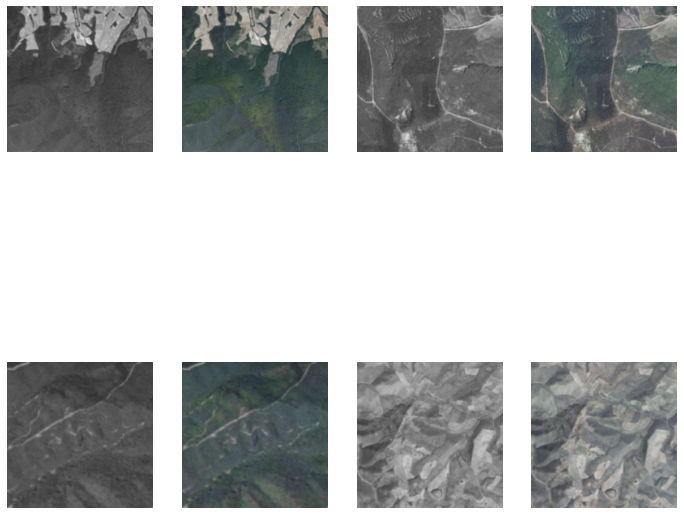

In [13]:
dls.show_batch(max_n=4, figsize=(12,12))

Como empiezan en walkwithfastai con ResNet34 es por donde empezaremos nosotros también.

In [14]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

In [15]:
learn = unet_learner(dls, models.resnet34, loss_func=loss_gen, y_range=y_range)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [16]:
learn.fit_one_cycle(2, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,time
0,19.388569,13.587141,00:14
1,14.686518,21.062807,00:09


In [17]:
learn.unfreeze()

In [18]:
learn.fit_one_cycle(20, slice(1e-6,1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,17.121897,13.380400,00:09
1,14.618810,6.344391,00:09
2,11.399739,4.967085,00:09
3,9.416598,3.443073,00:09
4,8.307019,3.346379,00:09
5,7.332929,3.074462,00:09
6,6.703722,3.024452,00:09
7,6.157670,2.982980,00:09
8,5.724369,2.940894,00:09
9,5.365546,2.917900,00:09


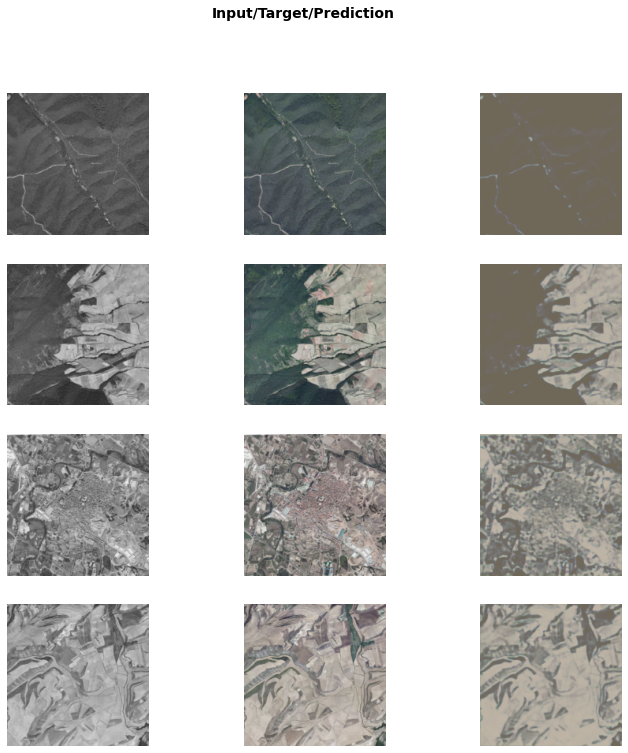

In [19]:
learn.show_results(max_n=4, figsize=(12,12))

Tenemos aquí varios problemas, los modelos ocupan demasiado en la GPU, y al principio teniamos 700 imagenes, redujimos a 200 y seguia sin caber, cambiamos la calidad de 800 a 180 las imágenes se ven realmente mal y el modelo no entrena nada bien, eh aquí el resultado.

#Modelo de Emile Wallner 

Ahora vamos a probar con un modelo que hay que entrenar pero que está pensado para el problema que necesitamos resolver.

In [1]:
!wget https://www.dropbox.com/s/8zr9fpfbth917oj/ImagenesTerritorio.zip?dl=0 -O imagenesTerritorio.zip

--2021-05-30 17:41:14--  https://www.dropbox.com/s/8zr9fpfbth917oj/ImagenesTerritorio.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/8zr9fpfbth917oj/ImagenesTerritorio.zip [following]
--2021-05-30 17:41:14--  https://www.dropbox.com/s/raw/8zr9fpfbth917oj/ImagenesTerritorio.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb6770be454d895b6466d62c653.dl.dropboxusercontent.com/cd/0/inline/BPfEYv9cUBvY9a034_OQ5owT9NiWI_kUk54k1Y-zMfvsm8SfjIlD_8nFrGlOCxbcQjnQf6x0VRViUtSdcb3XNIxexjH1vwFSh8InoyUwdJ8mDe69E7YV279IrCsD4Hm_QfzeFjSxb9e2iQjfywBUY7wT/file# [following]
--2021-05-30 17:41:15--  https://ucb6770be454d895b6466d62c653.dl.dropboxusercontent.com/cd/0/inline/BPfEYv9cUBvY9a034_OQ5owT9NiWI_kUk54k1Y-zMfvsm8SfjIlD_8n

In [2]:
!unzip imagenesTerritorio.zip

Archive:  imagenesTerritorio.zip
   creating: data/2014/Train/
  inflating: data/2014/Train/185086.jpg  
  inflating: data/2014/Train/185087.jpg  
  inflating: data/2014/Train/185088.jpg  
  inflating: data/2014/Train/185089.jpg  
  inflating: data/2014/Train/185090.jpg  
  inflating: data/2014/Train/185091.jpg  
  inflating: data/2014/Train/185092.jpg  
  inflating: data/2014/Train/185093.jpg  
  inflating: data/2014/Train/185094.jpg  
  inflating: data/2014/Train/186076.jpg  
  inflating: data/2014/Train/186077.jpg  
  inflating: data/2014/Train/186078.jpg  
  inflating: data/2014/Train/186079.jpg  
  inflating: data/2014/Train/186080.jpg  
  inflating: data/2014/Train/186081.jpg  
  inflating: data/2014/Train/186082.jpg  
  inflating: data/2014/Train/186083.jpg  
  inflating: data/2014/Train/186084.jpg  
  inflating: data/2014/Train/186085.jpg  
  inflating: data/2014/Train/186086.jpg  
  inflating: data/2014/Train/186087.jpg  
  inflating: data/2014/Train/186088.jpg  
  inflating: 

In [19]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
#from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from keras.models import Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow.python.keras.backend import set_session

In [20]:
tf.compat.v1.disable_eager_execution()

In [21]:
# Get images
X = []
for filename in os.listdir('data/2014/Train/'):
    X.append(img_to_array(load_img('data/2014/Train/'+filename,  target_size=(500,500))))
X = np.array(X, dtype=float)
Xtrain = 1.0/255*X


#Load weights
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.compat.v1.get_default_graph()
sess = tf.compat.v1.Session(graph=inception.graph)

In [22]:
embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

In [23]:
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        set_session(sess)
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
batch_size = 10

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)


In [24]:
#Train model      
model.compile(optimizer='rmsprop', loss='mse')
model.fit(image_a_b_gen(batch_size), epochs=1, steps_per_epoch=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2401: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


FailedPreconditionError: ignored

Llevamos más de 1 hora arreglando errores de librerias y APIs deprecated. Así que vamos a probar otros modelos. Que se encontrarán en otros Notebooks del repositorio.